In [37]:
# Based on Amar's matlab code
import numpy as np
from shapely.geometry import LineString, Point

import time

parameters = {}

parameters['time'] = time.strftime('%d%b%H%M', time.localtime())
parameters['doi_size'] = 1.5
parameters['alpha'] = 1e2
parameters['num_iter'] = 1,
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 1000  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz 2.4e9
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 40,  # dB
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1

def calculate_distance(point1, point2):
    return np.sqrt((point1[0]-point2[0])**2+(point1[1]-point2[1])**2)



def get_device_coordinates(parameters):
    doi_size = parameters['doi_size']
    num_deivces = len(parameters['device_indices'])

    line = LineString(((0.0, 0.0), (0.0, doi_size), (doi_size, doi_size), (doi_size, 0.0), (0.0, 0.0)))

    distances = np.linspace(0, line.length, num_deivces+1)

    points = [line.interpolate(distance) for distance in distances[:-1]]

    xx = [round(point.x, 3) for point in points]
    yy = [round(point.y, 3) for point in points]

    return xx, yy


def get_grid_coordinates(parameters):
    x = np.linspace(0.025, 1.475, int(parameters['doi_size']/parameters['grid_resolution']))

    y = np.linspace(0.025, 1.475, int(parameters['doi_size']/parameters['grid_resolution']))

    xx, yy = np.meshgrid(x, y)

    return xx, yy


device_xx, device_yy = get_device_coordinates(parameters)


grid_xx, grid_yy = get_grid_coordinates(parameters)

dist_txrx = np.zeros((parameters['num_devices'], parameters['num_devices']))
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        dist_txrx[tx][rx] = calculate_distance((device_xx[tx], device_yy[tx]), (device_xx[rx], device_yy[rx]))

dist_grid2device = np.zeros((int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution']), parameters['num_devices']))
for y in range(int(parameters['doi_size']/parameters['grid_resolution'])):
    for x in range(int(parameters['doi_size']/parameters['grid_resolution'])):
        for device in range(parameters['num_devices']):
            dist_grid2device[x][y][device] = (calculate_distance((grid_xx[x][y], grid_yy[x][y]), (device_xx[device], device_yy[device])))


In [38]:
F_RTI = np.zeros(((parameters['num_devices'])*(parameters['num_devices']-1), int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])))

idx = 0
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        if tx != rx:
            Thresh = 2*np.sqrt(dist_txrx[tx][rx]**2/4+parameters['detection_size']**2)
            foc_sum = dist_grid2device[:, :, rx] + dist_grid2device[:, :, tx]
            foc_sum[foc_sum>Thresh]=0
            foc_sum[foc_sum!=0]=1
            F_RTI[idx] = foc_sum
            idx += 1

F_RTI = F_RTI.reshape((parameters['num_devices'])*(parameters['num_devices']-1), -1)

In [39]:
start = time.time()

In [40]:
from functions import *

Pinc = np.load('result/Pinc.npy')
Pinc = magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0],dtype=bool)].reshape(-1,1)

In [41]:
Ptot = np.load('result/Ptot.npy')
Ptot = magnitude_to_db(abs(np.mean(np.squeeze(Ptot), axis=2)), parameters['receiver_gain'])
Ptot = Ptot[~np.eye(Ptot.shape[0],dtype=bool)].reshape(-1,1)

In [42]:
Pryt = Pinc - Ptot

In [43]:
output = np.matmul(np.linalg.solve((np.matmul(F_RTI.T, F_RTI) + parameters['alpha'] * np.identity((int(parameters['doi_size']/parameters['grid_resolution'])**2))),  F_RTI.T), Pryt)

In [44]:
output = output / output.max()

In [45]:
output[output<0] = 0

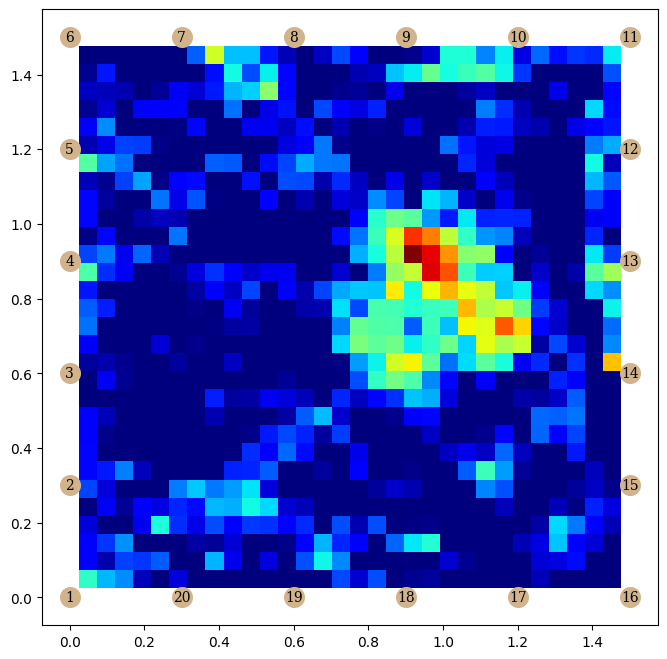

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

fontdict = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 10,
            }

plt.imshow(output.reshape((30,30)), extent=[0.025, 1.475, 0.025, 1.475], cmap='jet')

for i in range(parameters['num_devices']):
    plt.scatter(device_xx[i], device_yy[i], c='tan', s=200)
    plt.text(x=device_xx[i], y=device_yy[i]-0.01, s=i+1, fontdict=fontdict, ha='center')
plt.show()

In [47]:
import numpy as np
import time

parameters = {}

parameters['time'] = time.time()
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

# device parameters
parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 100  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 30  # dB
parameters['wavelength'] = 3e8/parameters['center_freq']

# imaging parameters
parameters['doi_size'] = 1.5
parameters['alpha'] = 0.05 #1e2
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1
parameters['pixel_size'] = (int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])) 

parameters['eterm'] = 1
parameters['k0'] = 2*np.pi/parameters['wavelength']

    
Pinc = np.load('result/Pinc.npy')
Ptot = np.load('result/Ptot.npy')

Pinc = magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0],dtype=bool)].reshape(-1,1)


Ptot = magnitude_to_db(abs(np.mean(np.squeeze(Ptot), axis=2)), parameters['receiver_gain'])
Ptot = Ptot[~np.eye(Ptot.shape[0],dtype=bool)].reshape(-1,1)

In [48]:
Pryt=(Ptot-Pinc)/(20*np.log10(np.exp(1)))

In [49]:
cellrad = (np.sqrt(parameters['grid_resolution']**2/np.pi)*2)/2

In [50]:
from scipy.special import hankel1, jv

E_d = (1j/4)*hankel1(0, parameters['k0']*dist_txrx)
E_inc = (1j/4)*hankel1(0, parameters['k0']*dist_grid2device)

In [51]:
E_d.shape
dist_txrx.shape


(20, 20)

In [52]:
E_inc.shape

(30, 30, 20)

In [53]:
Zryt.shape

NameError: name 'Zryt' is not defined

In [ ]:
Zryt=((1j*np.pi*cellrad/(2*parameters['k0']))*jv(1,parameters['k0']*cellrad)*hankel1(0, parameters['k0']*dist_grid2device.T))

In [ ]:
Fryt = np.zeros(((parameters['num_devices'])*(parameters['num_devices']-1), int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])), dtype=complex)

idx = 0
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        if tx != rx:
            Fryt[idx] = ((parameters['k0']**2)*((Zryt[rx, :, :]*(E_inc[:, :, tx]).T)/(E_d[tx][rx])))
            
            idx += 1

In [ ]:
FrytB = np.concatenate((Fryt.real, -Fryt.imag)).reshape(380, -1)

In [ ]:
FrytB.T.shape

In [ ]:
U_l = FrytB.shape[1]

In [ ]:
lambda_max = np.linalg.norm(np.matmul(FrytB.T, Pryt), ord=2)

In [ ]:
(np.matmul(FrytB.T, FrytB) + lambda_max * parameters['alpha'] * np.identity(U_l))

In [ ]:
# O = (FrytB.'*FrytB + lambda_max*alph*eye(U_l))\FrytB.'*Pryt

Oimag = np.matmul(np.linalg.solve((np.matmul(FrytB.T, FrytB) + lambda_max * parameters['alpha'] * np.identity(U_l)),  FrytB.T), Pryt)[parameters['pixel_size'][0]**2:]

In [ ]:
epr = 4*np.pi*(Oimag*0.5)/parameters['wavelength']

epr[epr < 0] = 0

In [ ]:

plt.figure(figsize=(8, 8))

fontdict = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 10,
            }

plt.imshow(epr.reshape((30,30)), extent=[0.025, 1.475, 0.025, 1.475], cmap='jet')

for i in range(parameters['num_devices']):
    plt.scatter(device_xx[i], device_yy[i], c='tan', s=200)
    plt.text(x=device_xx[i], y=device_yy[i]-0.01, s=i+1, fontdict=fontdict, ha='center')
plt.show()

In [ ]:
epr.max()

In [ ]:
import scipy.io


haha = scipy.io.loadmat("/home/lowong/Downloads/Forward_and_inverse_xPRA_RTI_codes - Anders/distanceED.mat")['distRxRn']

haha = np.array(haha)
haha.shape


In [ ]:
dist_grid2device.shape

In [ ]:
dist_grid2device.reshape(900, -1).T - haha

In [95]:
# load all the mat files into a dictionary with the names as keys
from pathlib import Path
import scipy.io

path = Path('Forward_and_inverse_xPRA_RTI_codes - Anders/')

mat_data = {}

for mat_file in path.glob('*.mat'):
    data = scipy.io.loadmat(mat_file)
    for key, value in data.items():
        if key not in ['__header__', '__version__', '__globals__']:
            mat_data[key] = value
            if value.shape == (1, 1):
                mat_data[key] = value.item()
            
mat_data.keys()

dict_keys(['freq', 'TxRx1', 'size_DOI', 'ty1', 'ym', 'ans', 'distRxRn', 'distTxRn', 'distTxRx', 'E_d', 'E_inc', 'Fryt', 'FrytB', 'Zryt', 'Ptot', 'E_ds1', 'epsono_r_c', 'E_s', 'Pinc', 'TxRxpairs', 'Ni', 'tx1', 'xm', 'epsono_rGT'])

In [97]:
mat_data['distTxRn']

array([[1.47521185, 1.50041661, 1.58311402, ..., 0.57554322, 0.87535707,
        1.17526593],
       [1.42521928, 1.45129253, 1.53663594, ..., 0.5255949 , 0.8253787 ,
        1.12527774],
       [1.37522725, 1.40223037, 1.49038586, ..., 0.47565744, 0.77540312,
        1.07529066],
       ...,
       [1.48028713, 1.18163023, 0.88388348, ..., 1.66620827, 1.54959672,
        1.48534508],
       [1.47690555, 1.17739118, 0.8782084 , ..., 1.69004438, 1.56564683,
        1.49206233],
       [1.47521185, 1.17526593, 0.87535707, ..., 1.71500729, 1.58311402,
        1.50041661]])

In [87]:
mat_data['ty1'].item()

ValueError: can only convert an array of size 1 to a Python scalar

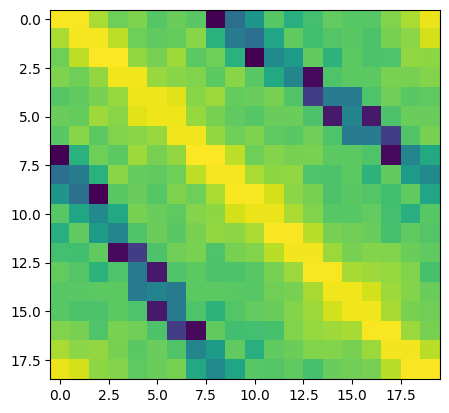

In [61]:
import matplotlib.pyplot as ply

ply.imshow(mat_data['Ptot'])

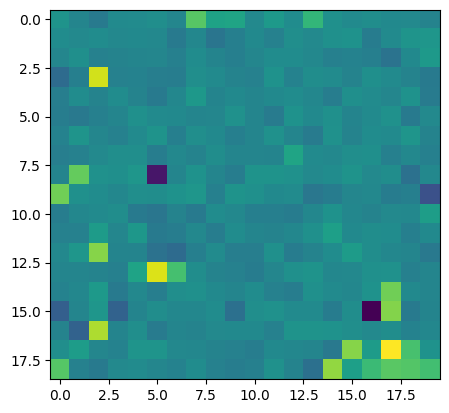

In [59]:
import numpy as np
from functions import *

Pinc = np.load('result/Pinc.npy')
Pinc = magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0],dtype=bool)].reshape(-1,1)
plt.imshow(Pinc.reshape(19, 20))

In [56]:
Pinc.shape

(380, 1)